# About

I reused my notebook in Tabular Playground Series - Jan 2021:  
https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline

<br>

* GBDT Models baseline
    * LightGBM, XGBoost, CatBoost
    * each model is trained by 5 folds cross validation


* feature engineering
    * **label-encoding** for category features
    * no feature engineering for continuous features


* inference test by **weighted** averaging 3 GBDT Models(5 folds averaging)

<br>

There is a lot of room for improvement such as feature engineering, parameter tuning, other models, and so on. enjoy ;) 


# Prepare

## import libraries

In [1]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool

%matplotlib inline

## read data

In [2]:
ROOT = Path.cwd().parent
INPUT = ROOT / "input"
DATA = INPUT / "tabular-playground-series-feb-2021"
WORK = ROOT / "working"

for path in DATA.iterdir():
    print(path.name)

sample_submission.csv
train.csv
test.csv


In [3]:
train = pd.read_csv(DATA / "train.csv")
test = pd.read_csv(DATA / "test.csv")
smpl_sub = pd.read_csv(DATA / "sample_submission.csv")
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

train: (300000, 26), test: (200000, 25), sample sub: (200000, 2)


In [4]:
train.head().T

,0,1,2,3,4
id,1,2,3,4,6
cat0,A,B,A,A,A
cat1,B,A,A,A,B
cat2,A,A,A,A,A
cat3,A,A,C,C,A
cat4,B,B,B,B,B
cat5,D,B,D,D,B
cat6,A,A,A,A,A
cat7,E,E,B,E,E
cat8,C,A,C,G,C


## Definition

In [5]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [6]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = None,
              cat_cols: list = None,
            ):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(
                X_train, label=y_train, cat_features=cat_cols)  #, group_id=[0] * len(X_train))
            self.val_data = Pool(
                X_val, label=y_val, cat_features=cat_cols)  #, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

# Training & Inference

## Config 

In [7]:
ID_COL = "id"
CAT_COLS= [f"cat{i}" for i in range(10)]
CONT_COLS = [f"cont{i}" for i in range(14)]
TGT_COL = "target"

N_SPLITS = 5
RANDOM_SEED_LIST = [
    42,
#   2021, 0, 1086, 39
]

MODEL_PARAMS = {
    "lgb": {
        "objective": "root_mean_squared_error",
        "boosting": "gbdt",
        "max_depth": 8,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "subsample_freq": 6,
        "reg_alpha": 6,
        "min_data_in_leaf": 200,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        # "device": "gpu",
        # "gpu_device_id": 0
    },
    "xgb": {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 200,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    },
    "cat": {
        'loss_function': 'RMSE',
        "max_depth": 4,
        'learning_rate': 0.02,
        "colsample_bylevel": 0.4,
        "subsample": 0.6,
        "bagging_temperature": 6,
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
#         "task_type": "GPU",
#         "devices" : "0",
        'num_boost_round': 20000,
        'grow_policy':'SymmetricTree',
        'od_type':'Iter', 
        'loss_function':'RMSE',
    }
}
TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval": 200,
    },
    "xgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval":  200,
    },
    "cat": {
        'early_stopping_rounds': 200,
        'verbose_eval': 200,
    }
}

## Feature Engineering

In [8]:
use_feat_cols = []
train_feat = train[[ID_COL]].copy()
test_feat = test[[ID_COL]].copy()

### for categorical features

apply label encoding using [`category_encoders.OrdinalEncoder`](https://contrib.scikit-learn.org/category_encoders/ordinal.html)

In [9]:
ord_enc = ce.OrdinalEncoder(cols=CAT_COLS)
train_cat_feat = ord_enc.fit_transform(train[CAT_COLS])
test_cat_feat = ord_enc.transform(test[CAT_COLS])

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
train_feat = pd.concat([
    train_feat, train_cat_feat], axis=1)
test_feat = pd.concat([
    test_feat, test_cat_feat], axis=1)
use_feat_cols.extend(train_cat_feat.columns)

### for continuous features

Use them as they are

In [11]:
train_cont_feat = train[CONT_COLS]
test_cont_feat = test[CONT_COLS]

In [12]:
train_feat = pd.concat([
    train_feat, train_cont_feat], axis=1)
test_feat = pd.concat([
    test_feat, test_cont_feat], axis=1)
use_feat_cols.extend(CONT_COLS)

In [13]:
train_feat.head().T

,0,1,2,3,4
id,1.000000,2.000000,3.000000,4.000000,6.000000
cat0,1.000000,2.000000,1.000000,1.000000,1.000000
cat1,1.000000,2.000000,2.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,1.000000,1.000000
cat3,1.000000,1.000000,2.000000,2.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,2.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,2.000000,1.000000,1.000000
cat8,1.000000,2.000000,1.000000,3.000000,1.000000


In [14]:
test_feat.head().T

,0,1,2,3,4
id,0.000000,5.000000,15.000000,16.000000,17.000000
cat0,1.000000,1.000000,1.000000,1.000000,1.000000
cat1,1.000000,1.000000,1.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,2.000000,1.000000
cat3,2.000000,2.000000,2.000000,1.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,1.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,1.000000,1.000000,1.000000
cat8,4.000000,1.000000,1.000000,4.000000,4.000000


## Training

In [15]:
def run_train_and_inference(
    X, X_test, y, use_model, model_params, train_params, seed_list, n_splits, cat_cols=None
):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
            print("*" * 100)
            print(f"Seed: {seed} - Fold: {fold}")
            X_trn = X.loc[trn_idx].reset_index(drop=True)
            X_val = X.loc[val_idx].reset_index(drop=True)
            y_trn = y[trn_idx]
            y_val = y[val_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params, cat_cols=cat_cols
                )
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[val_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances

In [16]:
X = train_feat[use_feat_cols]
X_test = test_feat[use_feat_cols]

y = train[TGT_COL].values

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

train_feat: (300000, 24), test_feat: (200000, 24)


### LightGBM

In [17]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.858774	valid_1's rmse: 0.860794
[400]	training's rmse: 0.849761	valid_1's rmse: 0.852641
[600]	training's rmse: 0.844931	valid_1's rmse: 0.848886
[800]	training's rmse: 0.841568	valid_1's rmse: 0.846661
[1000]	training's rmse: 0.838976	valid_1's rmse: 0.845265
[1200]	training's rmse: 0.83686	valid_1's rmse: 0.844291
[1400]	training's rmse: 0.835037	valid_1's rmse: 0.843685
[1600]	training's rmse: 0.833447	valid_1's rmse: 0.843255
[1800]	training's rmse: 0.831999	valid_1's rmse: 0.842957
[2000]	training's rmse: 0.830636	valid_1's rmse: 0.842773
[2200]	training's rmse: 0.829358	valid_1's rmse: 0.842608
[2400]	training's rmse: 0.828131	valid_1's rmse: 0.842482
[2600]	training's rmse: 0.826946	valid_1's rmse: 0.842362
[2800]	training's rmse: 0.825785	valid_1's rmse: 0.842286
[3000]	trai

In [18]:
score_lgb

,seed,fold,rmse score
0,42,0,0.842237
1,42,1,0.844036
2,42,2,0.842711
3,42,3,0.841504
4,42,4,0.840937
5,42,oof,0.842285
6,avg,oof,0.842285


In [19]:
score_lgb

,seed,fold,rmse score
0,42,0,0.842237
1,42,1,0.844036
2,42,2,0.842711
3,42,3,0.841504
4,42,4,0.840937
5,42,oof,0.842285
6,avg,oof,0.842285


In [20]:
score_lgb.loc[score_lgb.fold == "oof"]

,seed,fold,rmse score
5,42,oof,0.842285
6,avg,oof,0.842285


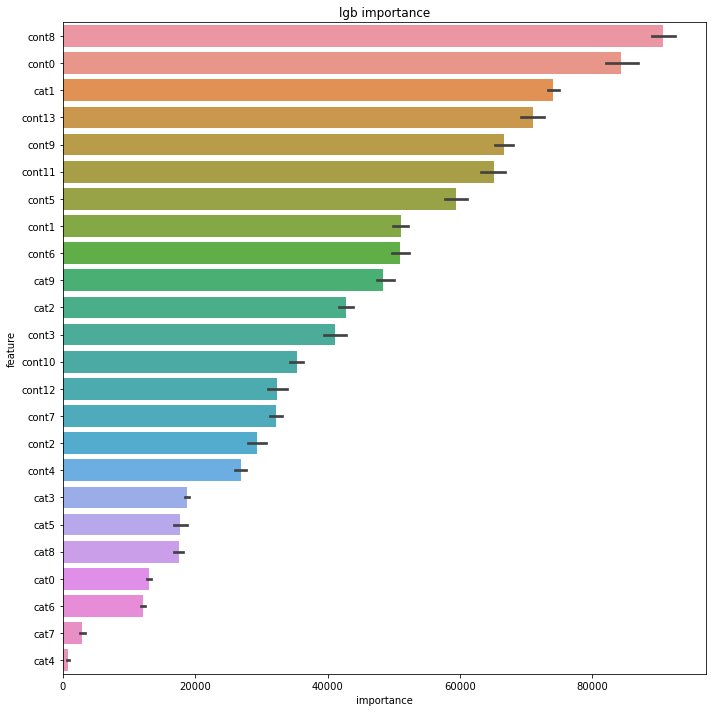

In [21]:
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

### XGBoost

In [22]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(
    X, X_test, y, "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
[0]	train-rmse:6.94369	val-rmse:6.94320
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[200]	train-rmse:1.26269	val-rmse:1.26338
[400]	train-rmse:0.85971	val-rmse:0.86273
[600]	train-rmse:0.84551	val-rmse:0.84998
[800]	train-rmse:0.84167	val-rmse:0.84742
[1000]	train-rmse:0.83892	val-rmse:0.84600
[1200]	train-rmse:0.83665	val-rmse:0.84498
[1400]	train-rmse:0.83461	val-rmse:0.84421
[1600]	train-rmse:0.83288	val-rmse:0.84368
[1800]	train-rmse:0.83130	val-rmse:0.84329
[2000]	train-rmse:0.82986	val-rmse:0.84300
[2200]	train-rmse:0.82854	val-rmse:0.84277
[2400]	train-rmse:0.82728	val-rmse:0.84260
[2600]	train-rmse:0.82609	val-rmse:0.84249
[2800]	train-rmse:0.82498	val-rmse:0.84238
[3000]	train-rmse:0.82386	val-rmse:0.84232
[3200]	train-rmse:0.82282	val-rmse:0.84227
[3400]	train-r

In [23]:
score_xgb

,seed,fold,rmse score
0,42,0,0.842191
1,42,1,0.844184
2,42,2,0.842887
3,42,3,0.841512
4,42,4,0.840755
5,42,oof,0.842307
6,avg,oof,0.842307


In [24]:
score_xgb.loc[score_xgb.fold == "oof"]

,seed,fold,rmse score
5,42,oof,0.842307
6,avg,oof,0.842307


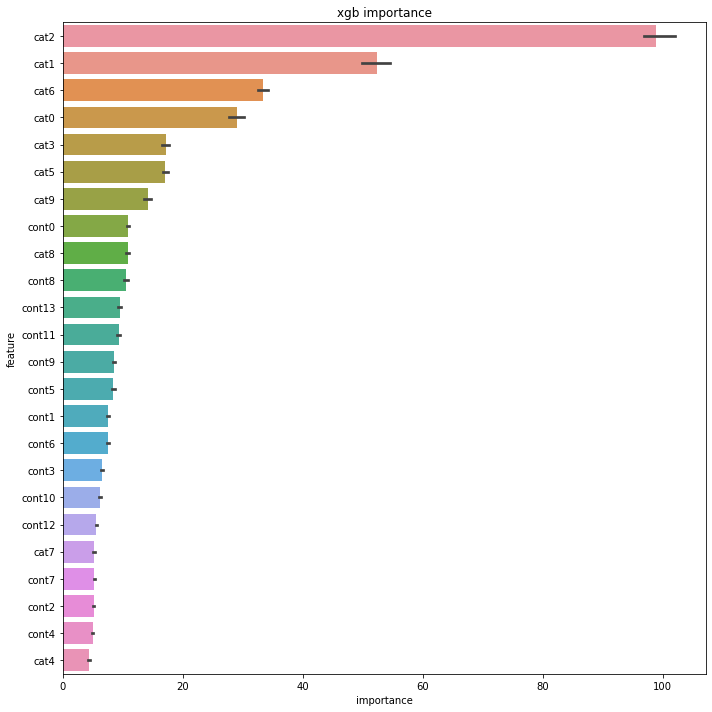

In [25]:
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

### CatBoost

In [26]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X, X_test, y, "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
0:	learn: 0.8867020	test: 0.8882525	best: 0.8882525 (0)	total: 102ms	remaining: 34m 8s
200:	learn: 0.8606933	test: 0.8612333	best: 0.8612333 (200)	total: 8.05s	remaining: 13m 12s
400:	learn: 0.8548360	test: 0.8552839	best: 0.8552839 (400)	total: 16.7s	remaining: 13m 36s
600:	learn: 0.8519342	test: 0.8524861	best: 0.8524861 (600)	total: 24.7s	remaining: 13m 17s
800:	learn: 0.8497054	test: 0.8505408	best: 0.8505408 (800)	total: 32.2s	remaining: 12m 52s
1000:	learn: 0.8479078	test: 0.8490639	best: 0.8490639 (1000)	total: 40.5s	remaining: 12m 48s
1200:	learn: 0.8464716	test: 0.8479353	best: 0.8479353 (1200)	total: 49.3s	remaining: 12m 52s
1400:	learn: 0.8452998	test: 0.8470822	best: 0.8470822 (1400)	total: 57.1s	remaining: 12m 37s
1600:	learn: 0.8442877	test: 0.8464304	best: 0.8464304 (1600)	total: 1m 4s	remaining: 12m 25s
1800:	learn: 0.8434156	test: 0.8458847	best: 0.84

In [27]:
score_cat

,seed,fold,rmse score
0,42,0,0.842731
1,42,1,0.844771
2,42,2,0.843850
3,42,3,0.842260
4,42,4,0.841692
5,42,oof,0.843062
6,avg,oof,0.843062


In [28]:
score_cat.loc[score_cat.fold == "oof"]

,seed,fold,rmse score
5,42,oof,0.843062
6,avg,oof,0.843062


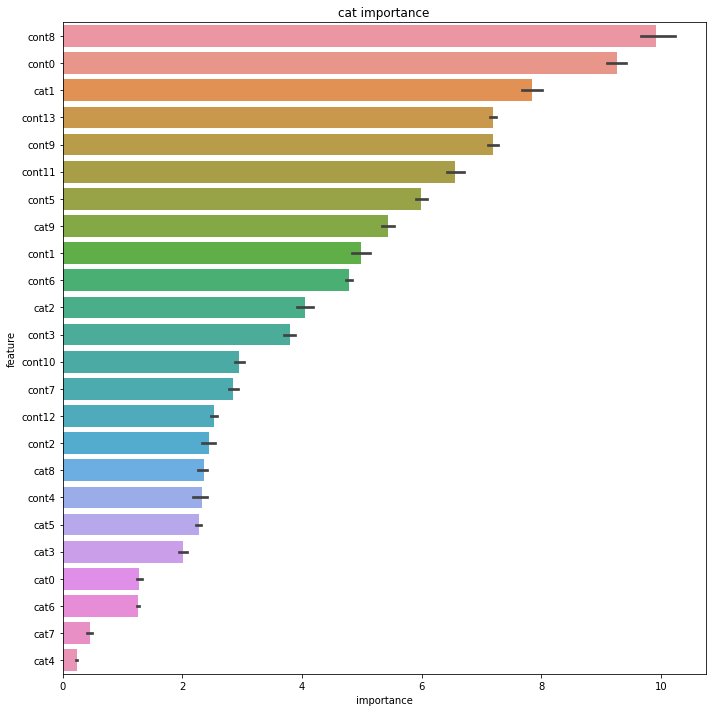

In [29]:
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

### Ensemble LGB, XGB, Cat

### check correlation

In [30]:
model_names = ["lgb", "xgb", "cat"]

In [31]:
# # prediction for oof
pd.DataFrame(
    np.corrcoef([
        oof_pred_lgb,
        oof_pred_xgb,
        oof_pred_cat
    ]),
    columns=model_names, index=model_names)

,lgb,xgb,cat
lgb,1.000000,0.993762,0.986684
xgb,0.993762,1.000000,0.988365
cat,0.986684,0.988365,1.000000


In [32]:
# # prediction for test
pd.DataFrame(
    np.corrcoef([
        test_pred_lgb,
        test_pred_xgb,
        test_pred_cat
    ]),
    columns=model_names, index=model_names)

,lgb,xgb,cat
lgb,1.000000,0.997535,0.990934
xgb,0.997535,1.000000,0.992350
cat,0.990934,0.992350,1.000000


### simple averaging

In [33]:
oof_pred_avg = (oof_pred_lgb + oof_pred_xgb + oof_pred_cat) / 3
oof_score_avg = mean_squared_error(y, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

test_pred_avg = (test_pred_lgb + test_pred_xgb + test_pred_cat) / 3

oof score avg: 0.84224


### weighted averaging

In [34]:
weights = [0.5, 0.4, 0.1]

oof_pred_wavg = weights[0] * oof_pred_lgb + weights[1] * oof_pred_xgb + weights[2] * oof_pred_cat
oof_score_wavg = mean_squared_error(y, oof_pred_wavg, squared=False)

print(f"oof score weighted avg: {oof_score_wavg:.5f}")

test_pred_wavg = weights[0] * test_pred_lgb + weights[1] * test_pred_xgb + weights[2] * test_pred_cat

oof score weighted avg: 0.84215


## Make submission

In [35]:
sub = smpl_sub.copy()
# sub[TGT_COL] = test_pred_avg
sub[TGT_COL] = test_pred_wavg

sub.to_csv("tps_submission.csv", index=False)

sub.head()

,id,target
0,0,7.678340
1,5,7.792634
2,15,7.598579
3,16,7.469492
4,17,7.258774
